In [2]:
%load_ext autoreload
%autoreload 2

import my_functions as ft
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# 2024-07-20: Train the model as it is (training failed bc kernel crashed (its overfitting))
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2= nn.Linear(64, 32)
        self.fc3= nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

def metric_function(output, y_batch):
	# Convert tensors to numpy arrays for easier manipulation
	output_np = output.numpy()
	y_batch_np = y_batch.numpy()

	# Initialize the metrics list
	metrics = []

	# Calculate metrics for each pair of output and ground truth
	for out, y in zip(output_np, y_batch_np):
		if out >= 0.5 and y == 1:
			metrics.append(2.0)
		elif out >= 0.5 and y == 0:
			metrics.append(-1.0)
		else:
			metrics.append(0.0)

	return metrics

def plot_metrics_function(metrics):
	plot_list = []

	for metric in metrics:
		if not isinstance(metric,list):
			metric = [metric]
		# Calculate the total profit
		profit = sum(metric)
		
		# Calculate the average profit per trade (only considering non-zero trades)
		non_zero_trades = [m for m in metric if m != 0]
		if len(non_zero_trades) > 0:
			average_profit_per_trade = profit / len(non_zero_trades)
		else:
			average_profit_per_trade = 0
		
		plot_list.append(average_profit_per_trade)

	# Create the plot
	plt.figure(figsize=(10, 5))

	# Plot the average profit per trade over time
	x_axis = np.arange(len(plot_list))
	plt.plot(x_axis, plot_list, color='black', label='Average Profit per Trade')

	# Fill areas with green or red depending on the profit
	plt.fill_between(x_axis, plot_list, where=(np.array(plot_list) >= 0.5), color='green', alpha=0.3)
	plt.fill_between(x_axis, plot_list, where=(np.array(plot_list) < 0.5), color='red', alpha=0.3)

	# Add a horizontal line at 0.0
	plt.axhline(0.5, color='black', linestyle='--')

	plt.xlabel('Epoch')
	plt.ylabel('Average Profit per Trade')
	plt.title('Average Profit per Trade Over Time')
	plt.legend()
	plt.show()

g_dataset_name = "BTCUSD_bad_dataset_1H_100candles_balanced" # Name of the zip (without .zip) where the data is stored and without _balanced
g_output_model_name = f"{g_dataset_name}_results" # Name of the output model (it will be saved in a folder with the same name)
g_this_nb_name="/home/oscar/qualentum/tfg/model_train.ipynb" # Name of this notebook (used to copy it in the output folder)
g_lines_per_file = 16384 # Amount of rows per csv file generated when saving the balanced dataset
g_batch_size = 32 # Amount of rows the model will se before updating its parameters
g_epochs = 250 # Number of times the model will loop through the data
g_learning_rate = 0.001 # Speed at which the model adjusts its parameters
g_train_percentage = 0.8 # Percentage of the whole dataset that goes into train and test (the value is the percentage of train data)
g_seed=42 # Seed for the random number generator
g_num_separations_confusion_matrix = 11 # How many different values will be used to round the predictions in the confusion matrix
g_early_stop_epochs = 20 # Number of epochs without the model improving the loss that stop the training (can be None to never stop)
g_min_improvement_percentage = 0.0 # Minimum improvement percentage to consider the model improved (in %)
g_debug_msg_interval = 10 # How many epochs between print messages of the loss
g_metric_function = metric_function # Function to calculate some metrics of the model when testing
g_plot_metrics_function = plot_metrics_function # Function to plot the metrics of the model when testing

g_device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use cuda if posible else cpu
g_model = Model(ft.count_columns(f'{g_dataset_name}/{g_dataset_name}_0.csv') - 1).to(g_device) # Model to be trained
g_loss_function= nn.BCELoss() # Binary Cross Entropy Loss
g_optimizer = optim.Adam(g_model.parameters(), lr=g_learning_rate, weight_decay=1e-5) # Adam optimizer



# Initialize the lists to store the losses and metrics
g_train_losses, g_test_losses, g_metrics = [],[],[] # Lists to store the losses and metrics (multiple executions of train don't reset the values)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate the loaders

In [3]:
# If no balanced dataset is found, try to generate it from the unbalanced dataset
if g_dataset_name.endswith('_balanced')\
	and not os.path.exists(g_dataset_name)\
	and not os.path.exists(f'{g_dataset_name}.zip'):
        tmp_unbalanced_dataset_name = g_dataset_name.replace('_balanced', '')
        print(f'Dataset {g_dataset_name}<.zip> not found. Trying to generate from {tmp_unbalanced_dataset_name}<.zip>.')
        g_df = ft.balance_dataset(ft.load_dataset(tmp_unbalanced_dataset_name), seed=g_seed)
        print(f'Saving balanced dataset {g_dataset_name}')
        ft.save_dataset(g_df, g_dataset_name, g_lines_per_file)

g_df = ft.load_dataset(g_dataset_name)

tmp_X = g_df.iloc[:, :-1].values
#tmp_X = tmp_X.reshape(-1, tmp_X.shape[1] // 5, 5) # Modify so each candle is a list
#tmp_X = tmp_X.transpose(0, 2, 1) # Change the order so each row is Open, High, Low, Close, Volume
tmp_y = g_df.iloc[:, -1].values

g_train_loader, g_test_loader = ft.create_data_loaders(
	X=tmp_X,
	y=tmp_y,
	batch_size=g_batch_size,
	train_percentage=g_train_percentage,
	shuffle=True,
	device=g_device,
	random_state=g_seed)


ft.del_tmp_vars()

## Visualize the loaders

Train dataset size: 30081
Test dataset size: 7521
Number of train batches: 941
Number of test batches: 236
Batch size: 32


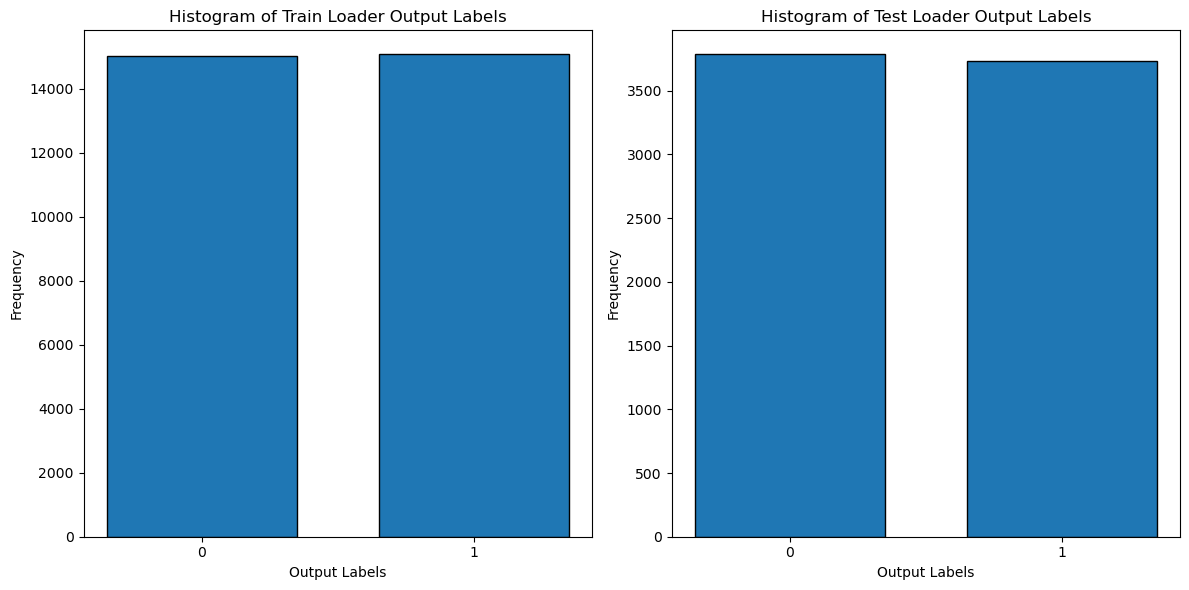

Ratio of 1s to 0s in train_loader: 1.00:1
Ratio of 1s to 0s in test_loader: 0.99:1


In [4]:
# Get the dataset size and number of batches
tmp_train_dataset_size = len(g_train_loader.dataset)
tmp_test_dataset_size = len(g_test_loader.dataset)
tmp_train_batches = len(g_train_loader)
tmp_test_batches = len(g_test_loader)

print(f'Train dataset size: {tmp_train_dataset_size}')
print(f'Test dataset size: {tmp_test_dataset_size}')
print(f'Number of train batches: {tmp_train_batches}')
print(f'Number of test batches: {tmp_test_batches}')
print(f'Batch size: {g_train_loader.batch_size}')

# Create histogram of labels in the training DataLoader
tmp_train_labels = []
for _, labels in g_train_loader:
    tmp_train_labels.extend(labels.cpu().numpy())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(tmp_train_labels, bins=[-0.5, 0.5, 1.5], edgecolor='black', rwidth=0.7)
plt.xticks([0, 1])
plt.xlabel('Output Labels')
plt.ylabel('Frequency')
plt.title('Histogram of Train Loader Output Labels')

# Create histogram of labels in the test DataLoader
tmp_test_labels = []
for _, labels in g_test_loader:
    tmp_test_labels.extend(labels.cpu().numpy())

plt.subplot(1, 2, 2)
plt.hist(tmp_test_labels, bins=[-0.5, 0.5, 1.5], edgecolor='black', rwidth=0.7)
plt.xticks([0, 1])
plt.xlabel('Output Labels')
plt.ylabel('Frequency')
plt.title('Histogram of Test Loader Output Labels')

plt.tight_layout()
plt.show()

# Calculate and print the ratio of labels 1 and 0 in train_loader and test_loader
tmp_train_ratio = sum(tmp_train_labels) / (len(tmp_train_labels) - sum(tmp_train_labels))
tmp_test_ratio = sum(tmp_test_labels) / (len(tmp_test_labels) - sum(tmp_test_labels))

print(f'Ratio of 1s to 0s in train_loader: {tmp_train_ratio:.2f}:1')
print(f'Ratio of 1s to 0s in test_loader: {tmp_test_ratio:.2f}:1')

ft.del_tmp_vars()

## Train the model

In [5]:
tmp_train_losses, tmp_test_losses, tmp_metrics = ft.train_model(
	model = g_model,
	train_loader = g_train_loader,
	test_loader = g_test_loader,
	loss_function = g_loss_function,
	optimizer = g_optimizer,
	metric_function = g_metric_function,
	epochs = g_epochs,
	debug_msg_interval = g_debug_msg_interval,
	early_stop_epochs = g_early_stop_epochs,
	min_improve_percentage = g_min_improvement_percentage
)
g_train_losses.extend(tmp_train_losses)
g_test_losses.extend(tmp_test_losses)
g_metrics.extend(tmp_metrics)

# Plot stuff
x_axis = range(len(g_train_losses))
plt.figure(figsize=(12, 10))
plt.plot(x_axis, g_train_losses, label='Train Loss')
plt.plot(x_axis, g_test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
ft.plot_confusion_matrix(g_model,g_test_loader,num_separations=g_num_separations_confusion_matrix)
ft.plot_predictions_density(g_model, g_test_loader)
if g_plot_metrics_function is not None:
	g_plot_metrics_function(g_metrics)

# Save the model and the notebook
if ft.prompt_user("Save model? [y,n]") in ['yes', 'y']:
    tmp_model_name, tmp_nb_name = ft.save_model(g_model, g_output_model_name, g_this_nb_name)
    print(f'Saving model to {tmp_model_name} and notebook to {tmp_nb_name}')
else:
    print('Model not saved.')

ft.del_tmp_vars()

# Test model with full dataset

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Define the function to print metrics
def tmp_print_metrics(metrics):
    profit = sum(metrics)

    # Calculate the average profit per trade (only considering non-zero trades)
    non_zero_trades = [m for m in metrics if m != 0]
    if len(non_zero_trades) > 0:
        average_profit_per_trade = profit / len(non_zero_trades)
    else:
        average_profit_per_trade = 0

    print(f'Average profit per trade: {average_profit_per_trade:.2f}')
    print(f'Percentage of candles traded: {len(non_zero_trades) / len(metrics) * 100.0:.2f}%')

# Load the dataset
tmp_df = ft.load_dataset(g_dataset_name[:-len("_balanced")])

# Prepare the input features
tmp_X = tmp_df.iloc[:, :-1].values
tmp_X = tmp_X.reshape(-1, tmp_X.shape[1] // 5, 5)  # Modify so each candle is a list
tmp_X = tmp_X.transpose(0, 2, 1)  # Change the order so each row is Open, High, Low, Close, Volume

# Prepare the labels
tmp_y = tmp_df.iloc[:, -1].values

# Convert to tensors and move to the appropriate device
tmp_X = torch.tensor(tmp_X, dtype=torch.float32).to(g_device)
tmp_y = torch.tensor(tmp_y, dtype=torch.float32).to(g_device)

# Create the dataset and data loader
tmp_dataset = TensorDataset(tmp_X, tmp_y)
tmp_loader = DataLoader(tmp_dataset, batch_size=g_batch_size, shuffle=False)

# Test the model
tmp_loss, tmp_metrics = ft.test_model(
    model=g_model,
    data_loader=tmp_loader,
    loss_function=g_loss_function,
    metric_function=metric_function
)

# Print the test loss and metrics
print(f'Test loss: {tmp_loss:.4f}')
tmp_print_metrics(tmp_metrics)

ft.plot_confusion_matrix(g_model, tmp_loader, num_separations=g_num_separations_confusion_matrix)
ft.plot_predictions_density(g_model, tmp_loader)
# Clean up temporary variables
ft.del_tmp_vars()


In [ ]:
# Save the model and the notebook
if ft.prompt_user("Save model? [y,n]") in ['yes', 'y']:
    tmp_model_name, tmp_nb_name = ft.save_model(g_model, g_output_model_name, g_this_nb_name)
    print(f'Saving model to {tmp_model_name} and notebook to {tmp_nb_name}')
else:
    print('Model not saved.')

Model not saved.
